In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [3]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


<ipython-input-4-ff1e07f1144f>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(labels[int(y_train[index])], fontsize=8)


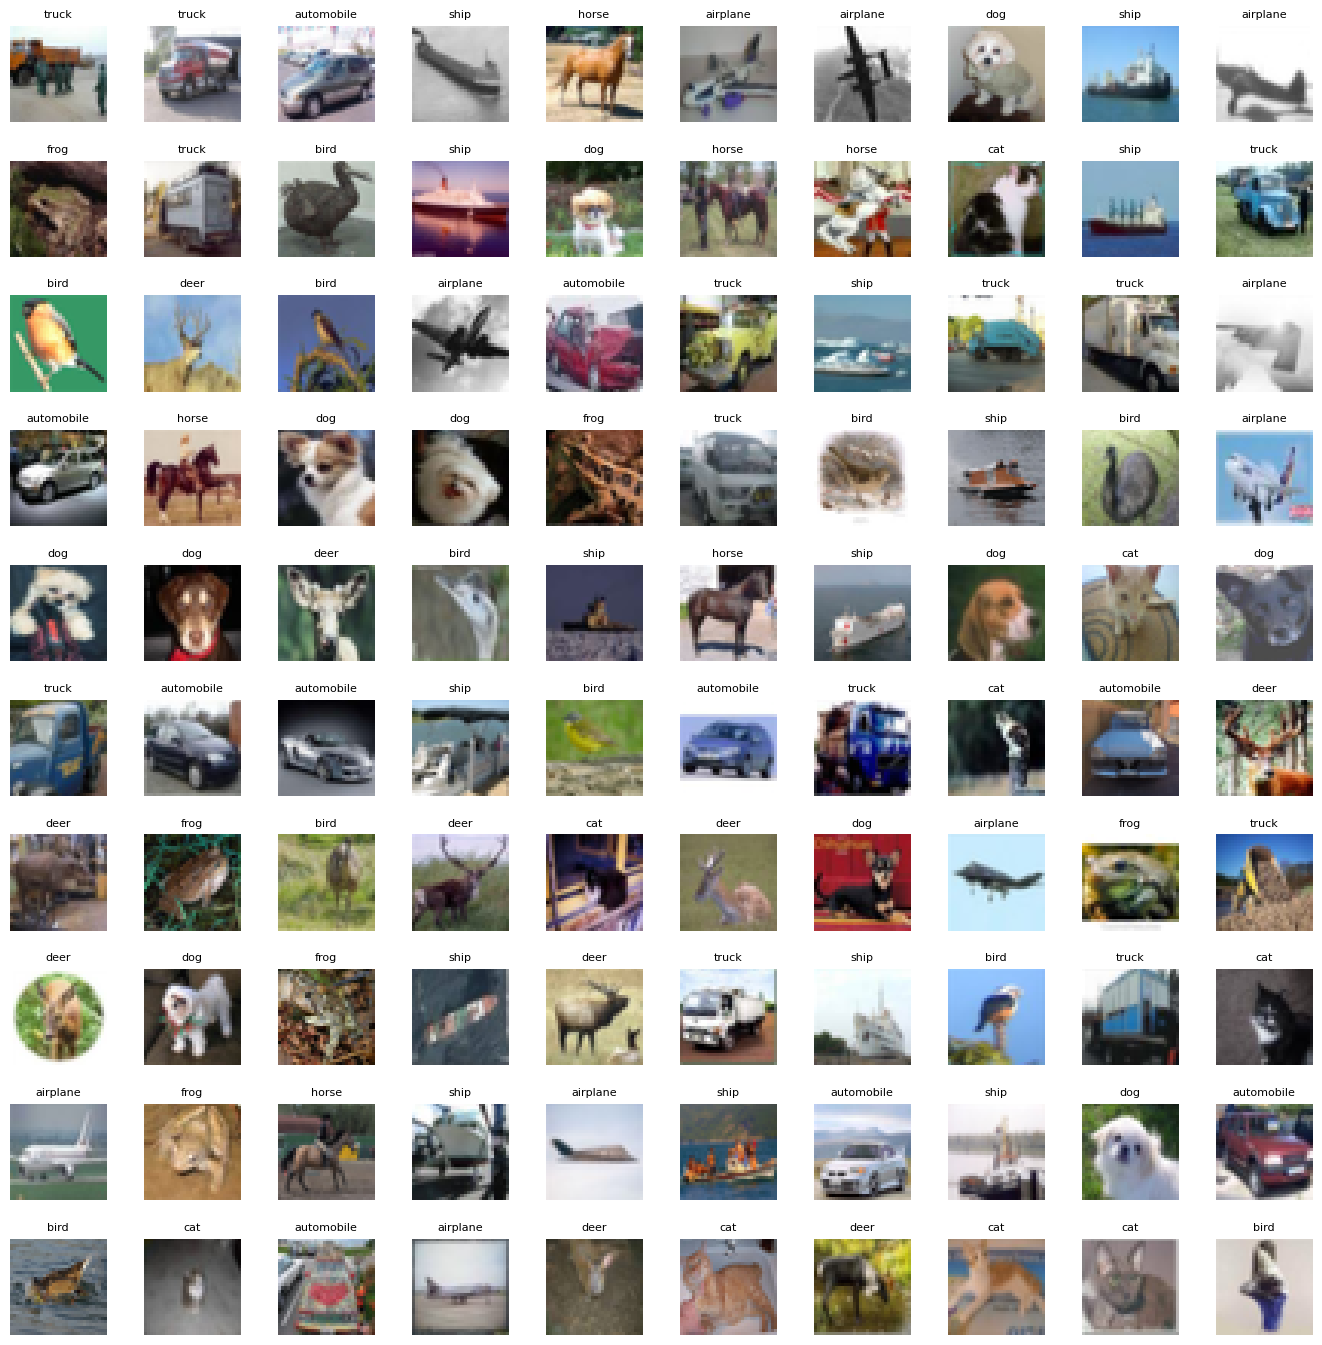

In [4]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

grid_width = 10
gird_length = 10

fig, axes = plt.subplots(gird_length, grid_width, figsize=(17, 17))

for ax in axes.ravel():
    index = np.random.randint(0, len(X_train))
    ax.imshow(X_train[index])
    ax.set_title(labels[int(y_train[index])], fontsize=8)
    ax.axis('off')

plt.subplots_adjust(hspace=0.4)
plt.show()

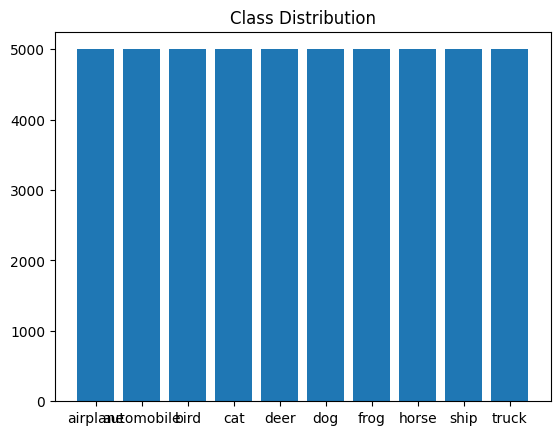

In [5]:
# graph for class distribution in dataset
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(labels, counts)
plt.title('Class Distribution')
plt.show()

In [6]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER = PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [7]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten,\
Conv2DTranspose, BatchNormalization, LeakyReLU, Reshape, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.express as px

In [8]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.15.0


In [9]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")

    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: Tesla T4


In [10]:
# input image dimensions
img_rows, img_cols = 32, 32

In [11]:
# Load CIFAR-10 dataset-
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [12]:
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

In [13]:
print(f"\ninput_shape to be used: {input_shape}")


input_shape to be used: (32, 32, 3)


In [14]:
# Specify hyper-parameters-
batch_size = 64
num_classes = 10
num_epochs = 100

In [15]:
# Convert datasets to floating point types-
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [16]:
# Normalize the training and testing datasets-
X_train /= 255.0
X_test /= 255.0

In [17]:
print("\nDimensions of training and testing sets are:")
print(f"X_train.shape: {X_train.shape} & X_test.shape: {X_test.shape}")


Dimensions of training and testing sets are:
X_train.shape: (50000, 32, 32, 3) & X_test.shape: (10000, 32, 32, 3)


In [18]:
# Create TF datasets-
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(50000).batch(batch_size = batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).shuffle(10000).batch(batch_size = batch_size)

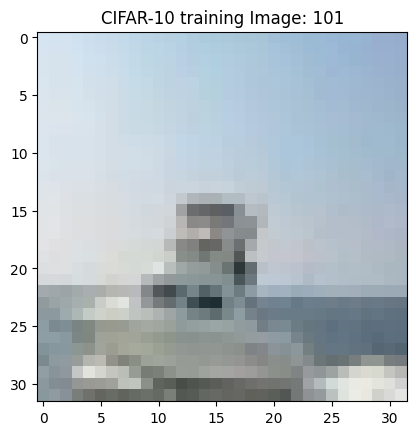

In [19]:
# Visualize one CIFAR-10 dataset-
img_idx = 100

plt.imshow(X_train[img_idx])
plt.title(f"CIFAR-10 training Image: {img_idx + 1}")
plt.show()

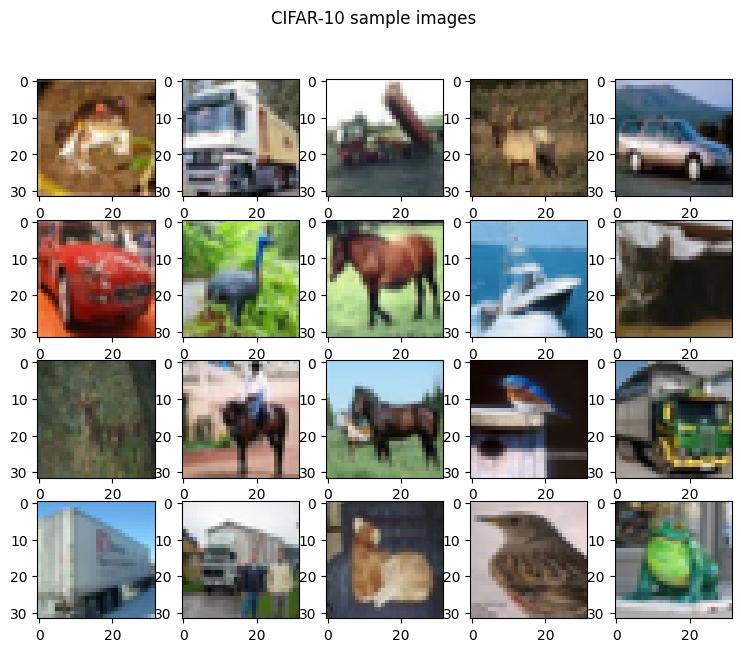

In [20]:
# Visualize 20 CIFAR-10 images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train[i], cmap = plt.get_cmap('gray'))

plt.suptitle("CIFAR-10 sample images")
plt.show()

In [21]:
class ConvBlock(Model):
    def __init__(
        self, num_filters,
        kernel_size, stride_length,
        pooling_size, pooling_stride,
        padding_type = 'same'
    ):
        super(ConvBlock, self).__init__()

        self.conv1 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False,
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv2 = Conv2D(
            filters = num_filters, kernel_size = kernel_size,
            strides = stride_length, padding = padding_type,
            activation = None, use_bias = False
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.pool = MaxPooling2D(
            pool_size = pooling_size,
            strides = pooling_stride
        )


    def call(self, x):
        x = tf.keras.activations.relu(self.bn(self.conv1(x)))
        x = tf.keras.activations.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        return x


In [22]:
class Conv6_Encoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Encoder, self).__init__()

        self.latent_dim = latent_dim

        self.conv_block1 = ConvBlock(
            num_filters = 64, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )

        self.conv_block2 = ConvBlock(
            num_filters = 128, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'valid'
            )

        self.conv_block3 = ConvBlock(
            num_filters = 256, kernel_size = 3,
            stride_length = 1, pooling_size = 2,
            pooling_stride = 2, padding_type = 'same'
            )

        self.flatten = Flatten()

        self.output_layer = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )


    def call(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.flatten(x)
        x = tf.keras.activations.relu(self.bn(self.output_layer(x)))
        return x


    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = self.conv_block1(x)
        print(f"conv_block1.shape: {x.shape}")
        x = self.conv_block2(x)
        print(f"conv_block2.shape: {x.shape}")
        x = self.conv_block3(x)
        print(f"conv_block3.shape: {x.shape}")
        x = self.flatten(x)
        print(f"flattened shape: {x.shape}")
        x = tf.keras.activations.relu(self.bn(self.output_layer(x)))
        print(f"Encoder output shape: {x.shape}")

        return None


In [23]:
class Conv6_Decoder(Model):
    def __init__(self, latent_dim = 10):
        super(Conv6_Decoder, self).__init__()

        self.latent_dim = latent_dim

        # self.inp_layer = InputLayer(input_shape = self.latent_dim)

        self.dense0 = Dense(
            units = self.latent_dim, activation = None
            )
        self.bn0 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.dense = Dense(
            units = 1024, activation = None
        )
        self.bn = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.dense2 = Dense(
            units = 4 * 4 * 256, activation = None
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.reshape = Reshape((4, 4, 256))

        self.conv_transpose_layer1 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn3 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer2 = Conv2DTranspose(
            filters = 256, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )

        self.bn4 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer3 =  Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn5 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer4 = Conv2DTranspose(
            filters = 128, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )

        self.bn6 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer5 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 2, padding = 'same',
            activation = None
            )
        self.bn7 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.conv_transpose_layer6 = Conv2DTranspose(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )

        self.bn8 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
            )

        self.final_conv_layer = Conv2DTranspose(
            filters = 3, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None
            )


    def call(self, X):
        # X = self.inp_layer(X)
        X = tf.keras.activations.relu(self.bn0(self.dense0(X)))
        X = tf.keras.activations.relu(self.bn(self.dense(X)))
        X = tf.keras.activations.relu(self.bn2(self.dense2(X)))
        X = self.reshape(X)
        X = tf.keras.activations.relu(self.bn3(self.conv_transpose_layer1(X)))
        X = tf.keras.activations.relu(self.bn4(self.conv_transpose_layer2(X)))
        X = tf.keras.activations.relu(self.bn5(self.conv_transpose_layer3(X)))
        X = tf.keras.activations.relu(self.bn6(self.conv_transpose_layer4(X)))
        X = tf.keras.activations.relu(self.bn7(self.conv_transpose_layer5(X)))
        X = tf.keras.activations.relu(self.bn8(self.conv_transpose_layer6(X)))
        # X = tf.keras.activations.sigmoid(self.final_conv_layer(X))
        X = self.final_conv_layer(X)

        return X


    def shape_computation(self, x):
        print(f"Input shape: {x.shape}")
        x = tf.nn.relu(self.bn0(self.dense0(x)))
        print(f"first dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn(self.dense(x)))
        print(f"second dense layer shape: {x.shape}")
        x = tf.nn.relu(self.bn2(self.dense2(x)))
        print(f"third dense layer shape: {x.shape}")
        x = self.reshape(x)
        print(f"reshape: {x.shape}")
        x = tf.nn.relu(self.bn3(self.conv_transpose_layer1(x)))
        print(f"conv transpose layer1 shape: {x.shape}")
        x = tf.nn.relu(self.bn4(self.conv_transpose_layer2(x)))
        print(f"conv transpose layer2 shape: {x.shape}")
        x = tf.nn.relu(self.bn5(self.conv_transpose_layer3(x)))
        print(f"conv transpose layer3 shape: {x.shape}")
        x = tf.nn.relu(self.bn6(self.conv_transpose_layer4(x)))
        print(f"conv transpose layer4 shape: {x.shape}")
        x = tf.nn.relu(self.bn7(self.conv_transpose_layer5(x)))
        print(f"conv transpose layer5 shape: {x.shape}")
        x = tf.nn.relu(self.bn8(self.conv_transpose_layer6(x)))
        print(f"conv transpose layer6 shape: {x.shape}")
        x = self.final_conv_layer(x)
        print(f"Decoder output shape: {x.shape}")

        return None

In [24]:
encoder = Conv6_Encoder(latent_dim = 100)

In [25]:
decoder = Conv6_Decoder(latent_dim = 100)

In [26]:
x = next(iter(train_dataset))

In [27]:
x.shape

TensorShape([64, 32, 32, 3])

In [28]:
x_enc = encoder(x)

In [29]:
x_recon = decoder(x_enc)

In [30]:
x_enc.shape

TensorShape([64, 100])

In [31]:
x.shape, x_recon.shape

(TensorShape([64, 32, 32, 3]), TensorShape([64, 32, 32, 3]))

In [32]:
encoder.shape_computation(x)

Input shape: (64, 32, 32, 3)
conv_block1.shape: (64, 14, 14, 64)
conv_block2.shape: (64, 5, 5, 128)
conv_block3.shape: (64, 2, 2, 256)
flattened shape: (64, 1024)
Encoder output shape: (64, 100)


In [33]:
decoder.shape_computation(x_enc)

Input shape: (64, 100)
first dense layer shape: (64, 100)
second dense layer shape: (64, 1024)
third dense layer shape: (64, 4096)
reshape: (64, 4, 4, 256)
conv transpose layer1 shape: (64, 8, 8, 256)
conv transpose layer2 shape: (64, 8, 8, 256)
conv transpose layer3 shape: (64, 16, 16, 128)
conv transpose layer4 shape: (64, 16, 16, 128)
conv transpose layer5 shape: (64, 32, 32, 64)
conv transpose layer6 shape: (64, 32, 32, 64)
Decoder output shape: (64, 32, 32, 3)


In [34]:
del encoder, decoder, x, x_enc, x_recon

In [35]:
class Sampling(tf.keras.layers.Layer):
    
    def call(self, mu, log_var):
    # def call(self, inputs):
        # z_mean, z_log_var = inputs

        # Get batch size-
        batch = tf.shape(mu)[0]

        # Get latent space dimensionality-
        dim = tf.shape(mu)[1]

        # Add stochasticity by sampling from a multivariate standard
        # Gaussian distribution-
        epsilon = tf.keras.backend.random_normal(
            shape = (batch, dim), mean = 0.0,
            stddev = 1.0
        )

        return mu + (tf.exp(0.5 * log_var) * epsilon)

In [36]:
class VAE(Model):
    def __init__(self, latent_space = 100):
        super(VAE, self).__init__()

        self.latent_space = latent_space

        self.encoder = Conv6_Encoder(latent_dim = self.latent_space)
        self.decoder = Conv6_Decoder(latent_dim = self.latent_space)

        # Define fully-connected layers for computing mean & log variance-
        self.mu = Dense(units = self.latent_space, activation = None)
        self.log_var = Dense(units = self.latent_space, activation = None)


    def reparameterize(self, mu, logvar):
        # Sample from a multivariate Gaussian distribution.
        # Adds stochasticity or variation-
        eps = tf.random.normal(
            shape = mu.shape, mean = 0.0,
            stddev = 1.0
        )
        return (eps * tf.exp(logvar * 0.5) + mu)


    def call(self, x):
        x = self.encoder(x)
        # print(f"x.shape: {x.shape}")
        # x.shape: (batch_size, 100)

        mu = self.mu(x)
        log_var = self.log_var(x)
        # z = self.reparameterize(mu, log_var)
        # z = Sampling()([mu, log_var])
        z = Sampling()(mu, log_var)

        x = tf.keras.activations.sigmoid(self.decoder(z))
        return x, mu, log_var


    def model(self):
        x = Input(shape = (32, 32, 3))
        return Model(inputs = [x], outputs = self.call(x))

In [37]:

model = VAE(latent_space = 100)

In [38]:

x = next(iter(train_dataset))

In [39]:

x_recon, mu, log_var = model(x)

In [40]:

model.model().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv6__encoder_1 (Conv6_En  (None, 100)                  1250996   ['input_1[0][0]']             
 coder)                                                                                           
                                                                                                  
 dense_8 (Dense)             (None, 100)                  10100     ['conv6__encoder_1[0][0]']    
                                                                                                  
 dense_9 (Dense)             (None, 100)                  10100     ['conv6__encoder_1[0][0]']

In [41]:

tot_params = 0

for layer in model.trainable_weights:
    loc_params = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_params
    print(f"layer: {layer.shape} has {loc_params} parameters")

layer: (3, 3, 3, 64) has 1728 parameters
layer: (64,) has 64 parameters
layer: (64,) has 0 parameters
layer: (3, 3, 64, 64) has 36864 parameters
layer: (64,) has 64 parameters
layer: (64,) has 0 parameters
layer: (3, 3, 64, 128) has 73728 parameters
layer: (128,) has 128 parameters
layer: (128,) has 0 parameters
layer: (3, 3, 128, 128) has 147456 parameters
layer: (128,) has 128 parameters
layer: (128,) has 0 parameters
layer: (3, 3, 128, 256) has 294912 parameters
layer: (256,) has 256 parameters
layer: (256,) has 0 parameters
layer: (3, 3, 256, 256) has 589824 parameters
layer: (256,) has 256 parameters
layer: (256,) has 0 parameters
layer: (1024, 100) has 102400 parameters
layer: (100,) has 0 parameters
layer: (100,) has 100 parameters
layer: (100,) has 0 parameters
layer: (100, 100) has 10000 parameters
layer: (100,) has 0 parameters
layer: (100,) has 100 parameters
layer: (100,) has 0 parameters
layer: (100, 1024) has 102400 parameters
layer: (1024,) has 0 parameters
layer: (1024,

In [42]:
# Define an optimizer-
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

In [43]:
def compute_loss(data, reconstruction, mu, log_var, alpha = 1):


    recon_loss = tf.reduce_mean(
        tf.reduce_sum(
            # tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
            tf.keras.losses.mean_squared_error(data, reconstruction),
            axis = (1, 2)
            )
        )

    # KL-divergence loss-
    kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    kl_loss = tf.reduce_mean(
        tf.reduce_sum(
            kl_loss,
            axis = 1
        )
    )


    # # Define beta (hyperparameter)
    # beta = 0.01  # You can adjust this value as needed

    # # Calculate KL-divergence loss with beta term
    # kl_loss = -0.5 * (1 + log_var - tf.square(mu) - tf.exp(log_var))
    # kl_loss = tf.reduce_mean(
    #     tf.reduce_sum(
    #         kl_loss,
    #         axis=1
    #     )
    # )
    # kl_loss *= beta  # Multiply by beta


    total_loss = (recon_loss * alpha) + kl_loss

    return total_loss, recon_loss, kl_loss

In [44]:
@tf.function
def train_one_step(model, optimizer, data, alpha):

    with tf.GradientTape() as tape:

        data_recon, mu, log_var = model(data)

        # Compute loss-
        total_loss, recon_loss, kl_loss = compute_loss(
            data = data, reconstruction = data_recon,
            mu = mu, log_var = log_var,
            alpha = alpha
        )

    grads = tape.gradient(total_loss, model.trainable_variables)


    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, recon_loss, kl_loss

In [45]:
@tf.function
def test_step(model, optimizer, data, alpha):

    # Make predictions using defined model-
    data_recon, mu, log_var = model(data)

    # Compute loss-
    total_loss, recon_loss, kl_loss = compute_loss(
        data = data, reconstruction = data_recon,
        mu = mu, log_var = log_var,
        alpha = alpha
    )

    return total_loss, recon_loss, kl_loss

In [46]:
print(f"Train VAE model for {num_epochs} epochs")

Train VAE model for 100 epochs


In [47]:
# Python3 dict to contain training metrics-
training_metrics = {}
val_metrics = {}

In [48]:
# Specify hyper-parameter for reconstruction loss vs. kl-divergence-
alpha = 10

In [49]:
for epoch in range(1, num_epochs + 1):


    # Epoch train & validation losses-
    train_loss = 0.0
    train_r_loss = 0.0
    train_kl_l = 0.0
    val_loss = 0.0
    val_r_loss = 0.0
    val_kl_l = 0.0

    for data in train_dataset:
        train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
            model = model, optimizer = optimizer,
            data = data, alpha = alpha
        )

        train_loss += train_total_loss.numpy()
        train_r_loss += train_recon_loss.numpy()
        train_kl_l += train_kl_loss.numpy()

    for test_data in test_dataset:
        test_total_loss, test_recon_loss, test_kl_loss = test_step(
            model = model, optimizer = optimizer,
            data = test_data, alpha = alpha)

        val_loss += test_total_loss.numpy()
        val_r_loss += test_recon_loss.numpy()
        val_kl_l += test_kl_loss.numpy()

    # vae_train_loss.append(train_loss)
    # vae_val_loss.append(val_loss)

    training_metrics[epoch] = {
        'total_loss': train_loss, 'recon_loss': train_r_loss,
        'kl_loss': train_kl_l
        }

    val_metrics[epoch] = {
        'total_loss': val_loss, 'recon_loss': val_r_loss,
        'kl_loss': val_kl_l
    }

    print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
    f" train recon loss = {train_r_loss:.4f}, train kl loss = {train_kl_l:.4f};"
    f" total val loss = {val_loss:.4f}, val recon loss = {val_r_loss:.4f} &"
    f" val kl loss = {val_kl_l:.4f}"
    )

epoch = 1; total train loss = 358486.5791, train recon loss = 34630.6061, train kl loss = 12180.5185; total val loss = 57030.6871, val recon loss = 5334.5795 & val kl loss = 3684.8922
epoch = 2; total train loss = 264796.6186, train recon loss = 24211.4299, train kl loss = 22682.3208; total val loss = 51426.4494, val recon loss = 4628.8598 & val kl loss = 5137.8509
epoch = 3; total train loss = 241157.2306, train recon loss = 21442.3707, train kl loss = 26733.5238; total val loss = 47510.1468, val recon loss = 4210.2285 & val kl loss = 5407.8621
epoch = 4; total train loss = 225765.3112, train recon loss = 19719.2333, train kl loss = 28572.9777; total val loss = 43484.8266, val recon loss = 3735.9116 & val kl loss = 6125.7103
epoch = 5; total train loss = 212008.1428, train recon loss = 18175.9842, train kl loss = 30248.3005; total val loss = 41486.5311, val recon loss = 3538.2531 & val kl loss = 6103.9998
epoch = 6; total train loss = 204757.3277, train recon loss = 17420.9274, train 

In [50]:
# Save trained model at the end of training-
model.save_weights("VAE_CIFAR10_last_epoch.h5", overwrite = True)

In [51]:
import pickle

# Save training metrics as pickle file-
with open("VAE_CIFAR10_training_metrics.pkl", "wb") as file:
    pickle.dump(training_metrics, file)

In [52]:
# Save validation metrics as pickle file-
with open("VAE_CIFAR10_training_metrics.pkl", "wb") as file:
    pickle.dump(val_metrics, file)

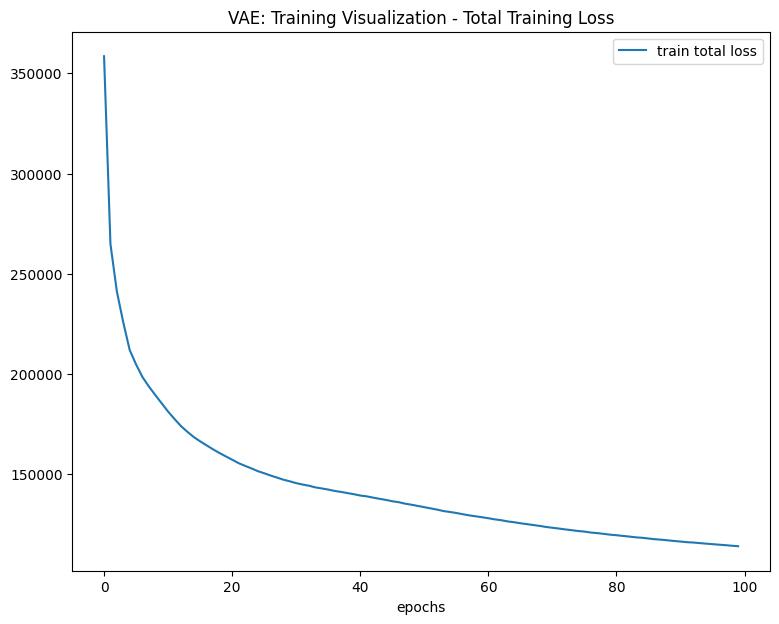

In [53]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['total_loss'] for e in training_metrics.keys()], label = 'train total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Total Training Loss")
plt.show()

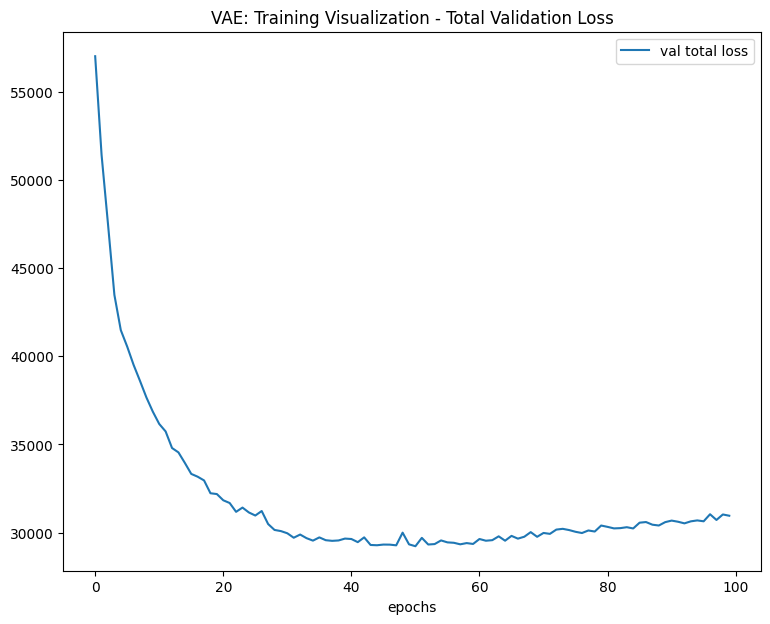

In [54]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['total_loss'] for e in val_metrics.keys()], label = 'val total loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Total Validation Loss")
plt.show()

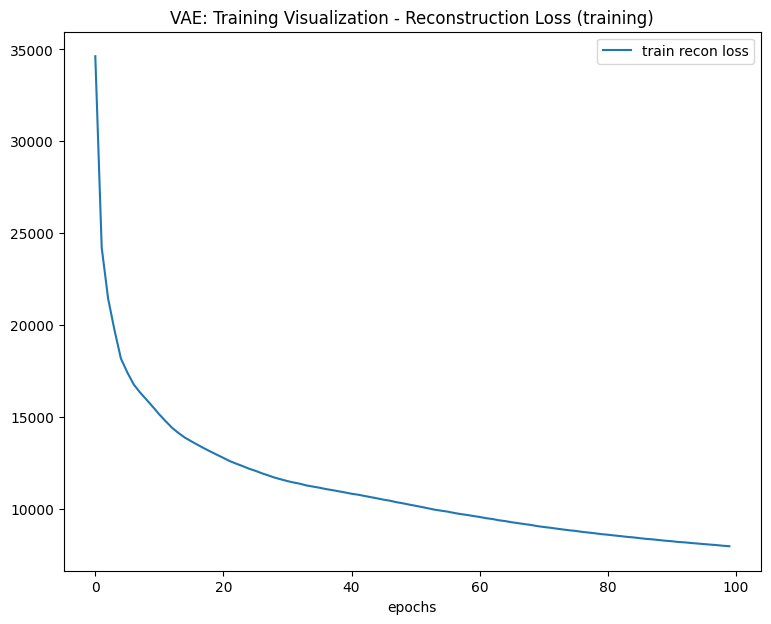

In [55]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['recon_loss'] for e in training_metrics.keys()], label = 'train recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (training)")
plt.show()

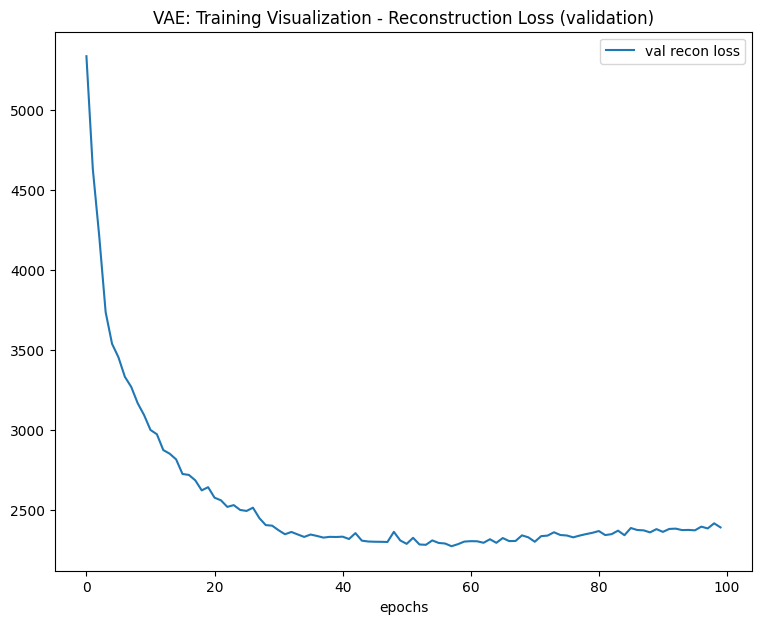

In [56]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['recon_loss'] for e in val_metrics.keys()], label = 'val recon loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - Reconstruction Loss (validation)")
plt.show()

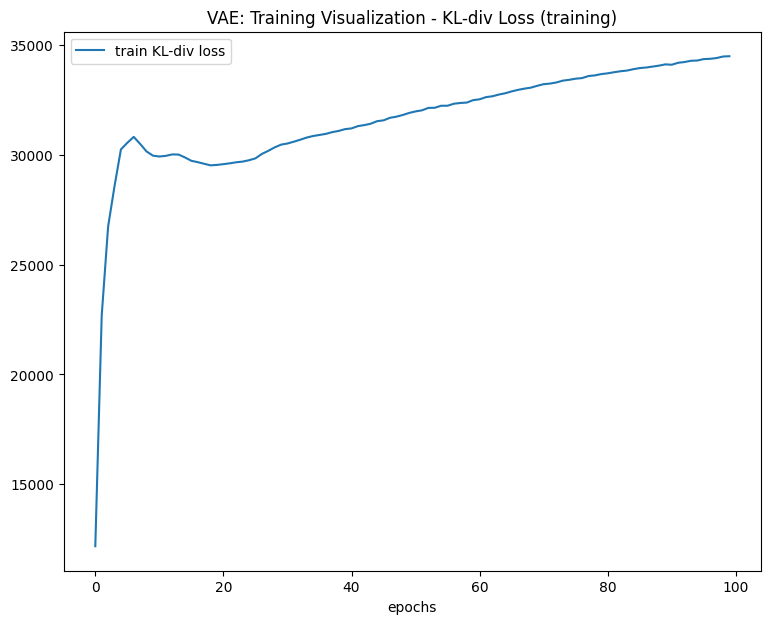

In [57]:
plt.figure(figsize = (9, 7))
plt.plot([training_metrics[e]['kl_loss'] for e in training_metrics.keys()], label = 'train KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (training)")
plt.show()

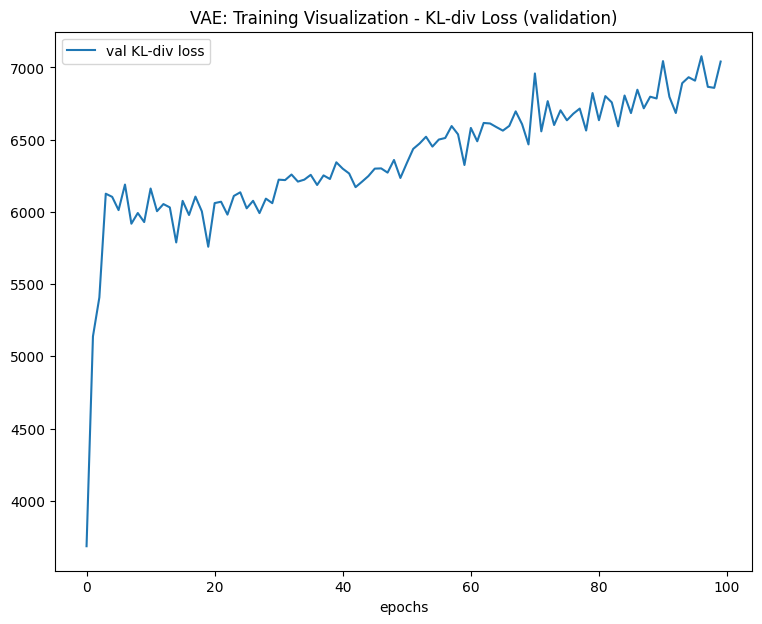

In [58]:
plt.figure(figsize = (9, 7))
plt.plot([val_metrics[e]['kl_loss'] for e in val_metrics.keys()], label = 'val KL-div loss')
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.title("VAE: Training Visualization - KL-div Loss (validation)")
plt.show()

In [59]:
# Get reconstructions, mean & log-variance from trained model-
X_train_reconstruced, mu, log_var = model(X_train[:1000, :])

In [60]:
# Sanity check-
X_train[:1000, :].shape, X_train_reconstruced.shape

((1000, 32, 32, 3), TensorShape([1000, 32, 32, 3]))

In [61]:
# Sanity check-
X_train_reconstruced.numpy().shape

(1000, 32, 32, 3)

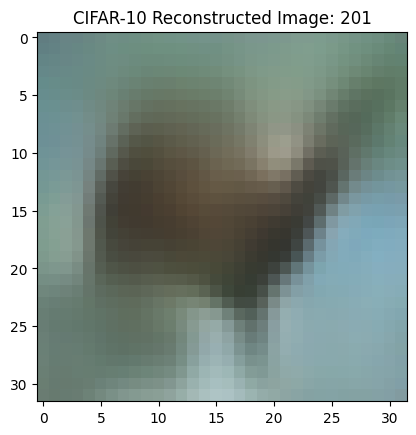

In [62]:
# Visualize one of reconstructed CIFAR-10 image-
img_idx = 200

plt.imshow(X_train_reconstruced[img_idx])
plt.title(f"CIFAR-10 Reconstructed Image: {img_idx + 1}")
plt.show()

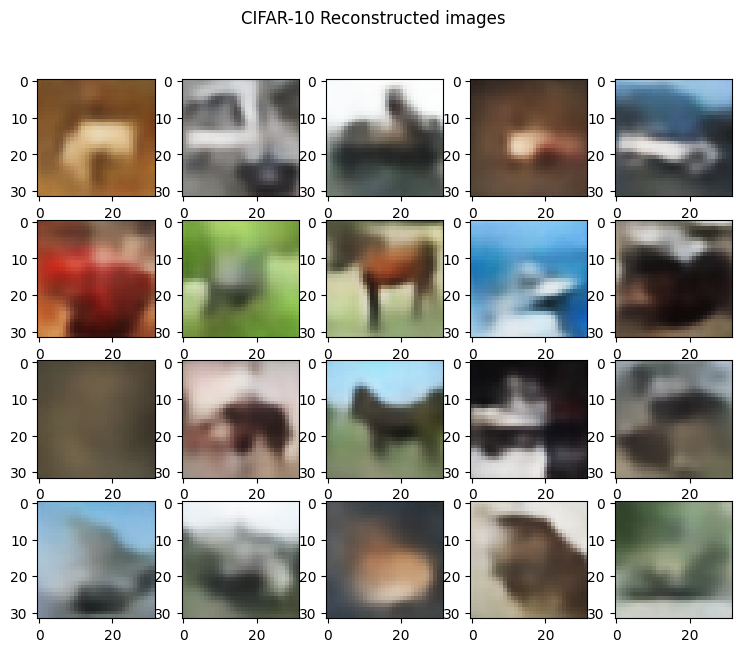

In [63]:
# Visualize 20 reconstruced images-
plt.figure(figsize = (9, 7))
for i in range(20):
    # 4 rows & 5 columns-
    plt.subplot(4, 5, i + 1)
    plt.imshow(X_train_reconstruced[i])

plt.suptitle("CIFAR-10 Reconstructed images")
plt.savefig('VAE_CIFAR10_Reconstructed_Images2.png')
plt.show()

In [69]:
# Generate images from the VAE model
num_samples = 10000  # Number of images to generate
latent_dim = 100  # Latent space dimension of the VAE
generated_images = []

for _ in range(num_samples):
    # Generate a random latent vector
    latent_vector = tf.random.normal(shape=(1, latent_dim))

    # Decode the latent vector to generate an image
    generated_image = model.decoder(latent_vector)

    # Append the generated image to the list
    generated_images.append(generated_image[0])

# Convert the list of generated images to a numpy array
generated_images = np.array(generated_images)


In [ ]:
# Preprocess the generated images to match the format expected by Inception v3
def preprocess_images(images):
    images = tf.image.resize(images, (299, 299))
    images = tf.keras.applications.inception_v3.preprocess_input(images)
    return images

# Preprocess the generated images
generated_images_preprocessed = preprocess_images(generated_images)


In [ ]:
def calculate_fid(images1, images2):
    # Load the pre-trained InceptionV3 model without the top classification layer
    inception_model = tf.keras.applications.InceptionV3(
        include_top=False, pooling='avg', input_shape=(299, 299, 3)
    )

    # Compute the activations for the real images
    activations1 = inception_model.predict(images1)

    # Compute the activations for the generated images
    activations2 = inception_model.predict(images2)

    # Compute the mean and covariance of the activations for the real images
    mu1, sigma1 = np.mean(activations1, axis=0), np.cov(activations1, rowvar=False)

    # Compute the mean and covariance of the activations for the generated images
    mu2, sigma2 = np.mean(activations2, axis=0), np.cov(activations2, rowvar=False)

    # Compute the squared difference between the means
    diff = mu1 - mu2
    # Compute the trace of the product of the covariances
    cov_mean = sigma1.dot(sigma2)
    trace = np.trace(sigma1 + sigma2 - 2 * np.sqrt(cov_mean))

    # Compute the FID score
    fid_score = np.sqrt(np.sum(diff**2) + trace)

    return fid_score


In [ ]:
# Compute the FID score between the generated images and the real CIFAR-10 images
fid_score = calculate_fid(X_test, generated_images_preprocessed)
print(f"FID Score: {fid_score}")


Hyperparameter tuning

In [ ]:
# perform hyperparameter tuning through loops
# Define hyperparameters-
batch_sizes = [32, 64, 128]
latent_dims = [50, 100, 150]
alphas = [1, 10, 100]

# Define number of epochs-
num_epochs = 100

# Define dictionary to store FID scores-
fid_scores = {}

for batch_size in batch_sizes:
    for latent_dim in latent_dims:
        for alpha in alphas:
            print(f"\nTraining VAE model for batch_size = {batch_size}, latent_dim = {latent_dim} & alpha = {alpha}")

            # Initialize VAE model-
            model = VAE(latent_space = latent_dim)

            # Define an optimizer-
            optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)

            # Python3 dict to contain training metrics-
            training_metrics = {}
            val_metrics = {}

            for epoch in range(1, num_epochs + 1):
                # Epoch train & validation losses-
                train_loss = 0.0
                train_r_loss = 0.0
                train_kl_l = 0.0
                val_loss = 0.0
                val_r_loss = 0.0
                val_kl_l = 0.0

                for data in train_dataset:
                    train_total_loss, train_recon_loss, train_kl_loss = train_one_step(
                        model = model, optimizer = optimizer,
                        data = data, alpha = alpha
                    )

                    train_loss += train_total_loss.numpy()
                    train_r_loss += train_recon_loss.numpy()
                    train_kl_l += train_kl_loss.numpy()

                for test_data in test_dataset:
                    test_total_loss, test_recon_loss, test_kl_loss = test_step(
                        model = model, optimizer = optimizer,
                        data = test_data, alpha = alpha)

                    val_loss += test_total_loss.numpy()
                    val_r_loss += test_recon_loss.numpy()
                    val_kl_l += test_kl_loss.numpy()

                training_metrics[epoch] = {
                    'total_loss': train_loss, 'recon_loss': train_r_loss,
                    'kl_loss': train_kl_l
                    }

                val_metrics[epoch] = {
                    'total_loss': val_loss, 'recon_loss': val_r_loss,
                    'kl_loss': val_kl_l
                }

                print(f"epoch = {epoch}; total train loss = {train_loss:.4f},"
                f" train recon loss = {train_r_loss:.4f}, train kl loss = {train_kl_l:.4f};"
                f" total val loss = {val_loss:.4f}, val recon loss = {val_r_loss:.4f} &"
                f" val kl loss = {val_kl_l:.4f}"
                )

